# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - putting some Frontier Models to the test.

### 2 important points:

It's important to appreciate that any actual training on the frontier models won't be done in this notebook section. But what's done will be just providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage which is good to keep in mind.

In [3]:
import os 
import re
import math 
import json 
import random 
from dotenv import load_dotenv
from huggingface_hub import login 
import matplotlib.pyplot as plt 
import numpy as np 
import pickle
from collections import Counter

### Frontier models:
from openai import OpenAI 
from anthropic import Anthropic 

### Internal classes: 
from items import Item 
from testing import Tester 

In [5]:
### Environment 

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
HF_TOKEN = os.getenv("HF_TOKEN")

login(HF_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
openai_client = OpenAI() 
claude_client = Anthropic()

In [7]:
%matplotlib inline

In [8]:
### Load pickle files of datasets: 

with open("train.pkl", "rb") as f: 
    train = pickle.load(f)

with open("test.pkl", "rb") as f: 
    test = pickle.load(f)

## Human Prediction Model

In [10]:
### Write the test set to a CSV 

import csv 

with open("human_input.csv", "w") as f: 
    writer = csv.writer(f)
    for t in test[:250]: 
        writer.writerow([t.test_prompt(), 0])

In [25]:
# Read it back in

human_predictions = []

with open("human_output.csv", "r") as f:
    reader = csv.reader(f)

    for row in reader:
        human_predictions.append(float(row[1]))

In [27]:
def human_pricer(item): 
    idx = test.index(item)
    print("IDX: ", idx)
    return human_predictions[idx]

In [ ]:
Tester.test(human_pricer, test)

In [32]:
test[0].test_prompt().replace(" to the nearest dollar", "").replace("Price is $", "")

'How much does this cost?\n\nSydney Rustic Mirror - Vanity Mirror, Bathroom Mirror, Farmhouse Decor, Wood Mirror, Large Mirror - 4 Sizes & 20 Colors - Red Oak\nThe Sydney low profile thin wood framed mirror will blend effortlessly in your current decor creating a simple yet sophisticated look. Our mirror features a reclaimed rustic styled wood finish, strong decorative lines with a thin 2.25” inch wide frame maximizing the visible mirror. This hanging mirror can be mounted horizontally or vertically. Available in 20 Colors - Shown in Red Oak. Not sure on color we do color samples please contact us for details. Available in 4 sizes, 24x30, 36x30, 42x30 & 60x30, all measurements are overall dimensions including frame and mirror. We offer two types\n\n'

## GPT-5-mini Prediction

In [34]:
# Strip out phrases such as:
# 1. to the nearest dollar
# 2. Price is $
### Reason: Now integrating with a GPT 5 model which is sophisticated enough 
### to handle it and understand without such guardrails 

def messages_for(item): 
    system_message = "You estimate the price of item. Reply only with the price without any additional explanation or comment."
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("Price is $", "")

    return [
        {"role": "system", "content": system_message}, 
        {"role": "user", "content": user_prompt}, 
        {"role": "assistant", "content": "Price is $"} # little trick to encourage the response followed in this form
    ]

In [ ]:
messages_for(test[0])

In [ ]:
### a utility function that extracts the price (float) 
### out of LLM's responses

def get_price(s: str): 
    s = s.replace("$", "").replace(",", "")
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [62]:
def gpt_5_pricer(item): 
    try:
        completion = openai_client.chat.completions.create(
            model="gpt-5-mini", 
            messages=messages_for(item)
        )
        response = completion.choices[0].message.content
        
        return get_price(response)
    except Exception as e: 
        print({e})
        continue

1: Guess: $119.00 Truth: $189.99 Error: $70.99 SLE: 0.22 Item: Sydney Rustic Mirror - Vanity Mirror, Ba...
2: Guess: $59.99 Truth: $64.45 Error: $4.46 SLE: 0.00 Item: Kimax 45050-25200 N-51A Borosilicate Gla...
3: Guess: $69.99 Truth: $128.99 Error: $59.00 SLE: 0.37 Item: FLAMMA FS21 Looper Pedal Drum Machine St...
4: Guess: $199.99 Truth: $252.70 Error: $52.71 SLE: 0.05 Item: Xiaomi Poco X5 5G, Dual SIM, 265GB + 8GB...
5: Guess: $6.99 Truth: $16.99 Error: $10.00 SLE: 0.66 Item: Vintage Farm Fresh Milk Stencil by Studi...
6: Guess: $549.00 Truth: $499.99 Error: $49.01 SLE: 0.01 Item: HP 2021 Flagship 15 Laptop Computer 15.6...
7: Guess: $599.00 Truth: $363.36 Error: $235.64 SLE: 0.25 Item: 3B Scientific G13 Heart w/ Oesophagus a....
8: Guess: $29.95 Truth: $24.75 Error: $5.20 SLE: 0.03 Item: Noctua NF-F12 PWM chromax.Black.swap, Pr...
9: Guess: $44.99 Truth: $65.20 Error: $20.21 SLE: 0.13 Item: Knitter's Pride Bamboo Knitting Needles ...
10: Guess: $129.00 Truth: $189.95 Error: $60.95 

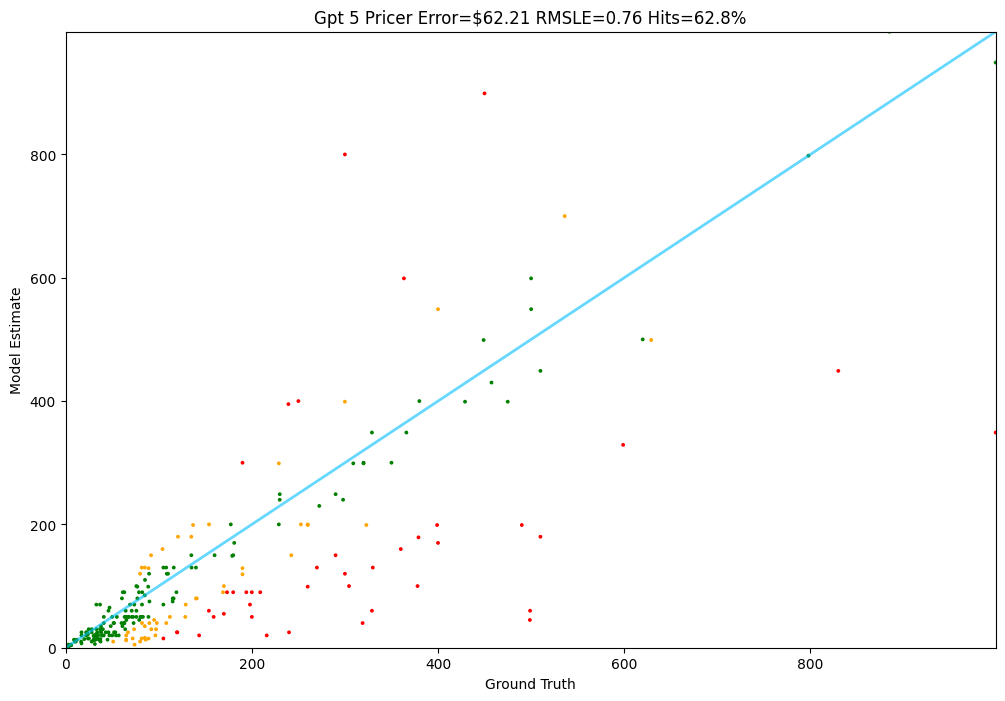

In [63]:
Tester.test(gpt_5_pricer, test)